In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import cv2
from PIL import Image,ImageOps
from PIL import ImageDraw 
import shutil
import os
from PIL import Image
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array
from keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Conv2D, Concatenate, Flatten, Add, Dropout, GRU
import random
import datetime
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
from google.colab import drive 
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Medical_report_generation_2023/Reboot/Results/MedGen-main/MedGen-main/data/traindata.csv',nrows=1000)

In [ ]:
train.head()

,Unnamed: 0,patient_id,image1_id,image2_id,report
0,0,CXR3080_IM-1440,CXR3080_IM-1440-1001,CXR3080_IM-1440-1002,startseq the cavity and the left upper lobe ha...
1,1,CXR2721_IM-1183,CXR2721_IM-1183-1001,CXR2721_IM-1183-2001,startseq heart size at the upper limits of nor...
2,2,CXR2160_IM-0778,CXR2160_IM-0778-1001,CXR2160_IM-0778-2001,startseq the cardiomediastinal silhouette is w...
3,3,CXR3586_IM-1764,CXR3586_IM-1764-1001,CXR3586_IM-1764-2001,startseq the heart is mildly enlarged the medi...
4,4,CXR3139_IM-1476,CXR3139_IM-1476-1001,CXR3139_IM-1476-2001,startseq no focal areas of consolidation no pl...


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Medical_report_generation_2023/Reboot/Results/MedGen-main/MedGen-main/data/testdata.csv',nrows=200)

In [ ]:
test.head()

,Unnamed: 0,patient_id,image1_id,image2_id,report
0,0,CXR1306_IM-0200,CXR1306_IM-0200-2001,CXR1306_IM-0200-3001,startseq the examination consists of frontal ...
1,1,CXR1786_IM-0512,CXR1786_IM-0512-1001,CXR1786_IM-0512-2001,startseq the lungs are clear bilaterally speci...
2,2,CXR2072_IM-0706,CXR2072_IM-0706-1001,CXR2072_IM-0706-2001,startseq stable nonenlarged cardiomediastinal ...
3,3,CXR467_IM-2095,CXR467_IM-2095-2001,CXR467_IM-2095-2001,startseq lungs are clear bilaterally cardiac a...
4,4,CXR3087_IM-1444,CXR3087_IM-1444-1001,CXR3087_IM-1444-2001,startseq the heart is enlarged the mediastinal...


In [ ]:
train.drop('Unnamed: 0',axis='columns',inplace=True)
test.drop('Unnamed: 0',axis='columns',inplace=True)

In [ ]:
train.head()

,patient_id,image1_id,image2_id,report
0,CXR3080_IM-1440,CXR3080_IM-1440-1001,CXR3080_IM-1440-1002,startseq the cavity and the left upper lobe ha...
1,CXR2721_IM-1183,CXR2721_IM-1183-1001,CXR2721_IM-1183-2001,startseq heart size at the upper limits of nor...
2,CXR2160_IM-0778,CXR2160_IM-0778-1001,CXR2160_IM-0778-2001,startseq the cardiomediastinal silhouette is w...
3,CXR3586_IM-1764,CXR3586_IM-1764-1001,CXR3586_IM-1764-2001,startseq the heart is mildly enlarged the medi...
4,CXR3139_IM-1476,CXR3139_IM-1476-1001,CXR3139_IM-1476-2001,startseq no focal areas of consolidation no pl...


In [ ]:
test.head()

,patient_id,image1_id,image2_id,report
0,CXR1306_IM-0200,CXR1306_IM-0200-2001,CXR1306_IM-0200-3001,startseq the examination consists of frontal ...
1,CXR1786_IM-0512,CXR1786_IM-0512-1001,CXR1786_IM-0512-2001,startseq the lungs are clear bilaterally speci...
2,CXR2072_IM-0706,CXR2072_IM-0706-1001,CXR2072_IM-0706-2001,startseq stable nonenlarged cardiomediastinal ...
3,CXR467_IM-2095,CXR467_IM-2095-2001,CXR467_IM-2095-2001,startseq lungs are clear bilaterally cardiac a...
4,CXR3087_IM-1444,CXR3087_IM-1444-1001,CXR3087_IM-1444-2001,startseq the heart is enlarged the mediastinal...


In [ ]:
train.shape, test.shape

((1000, 4), (200, 4))

In [ ]:
X_train, X_test = train['patient_id'], test['patient_id']
y_train, y_test = train['report'], test['report']

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1000,), (1000,), (200,), (200,))

In [ ]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(y_train.values)  

In [ ]:
os.chdir('/content/drive/MyDrive/Medical_report_generation_2023/Reboot/Results/MedGen-main/MedGen-main/')

In [ ]:
!pwd

/content/drive/MyDrive/Medical_report_generation_2023/Reboot/Results/MedGen-main/MedGen-main


In [ ]:
with open("token.pickle", "wb") as f:
    pickle.dump(tokenizer, f)

In [ ]:
with open('/content/drive/MyDrive/Medical_report_generation_2023/Reboot/Results/MedGen-main/MedGen-main/features/list_train_features.pkl', 'rb') as f:
    train_feat_list = pickle.load(f)

In [ ]:
with open('/content/drive/MyDrive/Medical_report_generation_2023/Reboot/Results/MedGen-main/MedGen-main/features/list_test_features.pkl', 'rb') as f:
    test_feat_list = pickle.load(f)

In [ ]:
len(train_feat_list)

1000

In [ ]:
len(test_feat_list)

200

In [ ]:
f = open('/content/drive/MyDrive/Medical_report_generation_2023/Reboot/Results/MedGen-main/MedGen-main/glove.840B.300d.pkl','rb') # 300d glove vectors  
glove_vectors = pickle.load(f)
f.close()

In [ ]:
vocab_size = len(tokenizer.word_index.keys()) + 1

In [ ]:
vocab_size

1072

In [ ]:
embedding_matrix = np.zeros((vocab_size,300))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors.keys():
        vec = glove_vectors[word]
        embedding_matrix[i] = vec
    else:
        continue

In [ ]:
os.chdir('/content/drive/MyDrive/Medical_report_generation_2023/Reboot/Results/MedGen-main/MedGen-main/')

In [ ]:
!pwd

/content/drive/MyDrive/Medical_report_generation_2023/Reboot/Results/MedGen-main/MedGen-main


In [ ]:
# np.save('emb_mat.npy',embedding_matrix)

In [ ]:
batch_size = 15

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_feat_list,y_train))
train_dataset = train_dataset.shuffle(300).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_feat_list,y_test))
test_dataset = test_dataset.shuffle(300).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
def load_data(images,reports_unpadded):
    imgs = []
    input_reports = []
    output_reports = []
    for i in range(len(images)):
        sequence=[] 
        for rep in reports_unpadded[i].split(" "):
            if rep in tokenizer.word_index.keys():
                sequence.append(tokenizer.word_index[rep])
        for j in range(1,len(sequence)):
            in_seq = sequence[:j]          
            out_seq = sequence[j]            
            out_seq = tf.keras.utils.to_categorical(out_seq, num_classes=vocab_size)
            imgs.append(images[i])            
            input_reports.append(in_seq)            
            output_reports.append(out_seq)
        
    return np.array(imgs), np.array(input_reports), np.array(output_reports)

In [ ]:
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='auto')
def maskedLoss(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    loss_ = loss_function(y_true, y_pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ = loss_*mask
    loss_ = tf.reduce_mean(loss_)
    return loss_

In [ ]:
max_len=80

In [ ]:
input_1=Input(shape=(2048),name="Images")
encoder_out=Dense(512,activation="relu",name="enc_dense")(input_1)


#decoder model
input_text=Input(shape=(max_len),name="text")

embedding_out=tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=300,input_length=max_len,mask_zero=True,trainable=False,weights=[embedding_matrix])(input_text)

lstm_out1= LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), return_sequences=True, name="LSTM1")(embedding_out)

lstm_out2= LSTM(units=512, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), name="LSTM2")(lstm_out1) 

x=Dropout(0.35)(lstm_out2)
add=tf.keras.layers.Add()([encoder_out, x])
  
x=Dense(512,kernel_initializer=tf.keras.initializers.he_normal(seed=1),activation="relu")(add)

x1=Dropout(0.25)(x)

x1=Dense(vocab_size,activation="softmax")(x1)
#encoder_decoder_model
encoder_decoder=Model(inputs=[input_1,input_text],outputs=x1)
encoder_decoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, 80)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 80, 300)      321600      ['text[0][0]']                   
                                                                                                  
 LSTM1 (LSTM)                   (None, 80, 256)      570368      ['embedding[0][0]']              
                                                                                                  
 Images (InputLayer)            [(None, 2048)]       0           []                               
                                                                                              

In [ ]:
encoder_decoder.compile(optimizer="Adam", loss = maskedLoss)

In [ ]:
train_loss_list = []

for epoch in range(15):
    print('EPOCH : ',epoch+1)
    batch_loss_train = 0
    
    for img, report in train_dataset:        
        r1 = [word.decode('utf-8') for word in np.array(report)]  
        img_input, rep_input, output_word = load_data(img.numpy(), r1)
        rep_input = tf.keras.preprocessing.sequence.pad_sequences(rep_input, maxlen=80, padding='post')
        img_input=tf.reshape(img_input,shape=(img_input.shape[0],img_input.shape[-1]))        
        loss = encoder_decoder.train_on_batch([img_input, rep_input], output_word)        
        batch_loss_train += loss

    train_loss = batch_loss_train/(len(y_train)//15)
    print('Training Loss: {}'.format(train_loss))
    
encoder_decoder.save_weights('/content/drive/MyDrive/Medical_report_generation_2023/Reboot/Results/MedGen-main/MedGen-main/epochs/'+ str(epoch+1))

EPOCH :  1


<ipython-input-30-2647318daa3e>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(imgs), np.array(input_reports), np.array(output_reports)


Training Loss: 0.0048655813178894195
EPOCH :  2
Training Loss: 0.004305475624278188
EPOCH :  3
Training Loss: 0.0038947385072595243
EPOCH :  4
Training Loss: 0.003412797087521264
EPOCH :  5
Training Loss: 0.002956861287891639
EPOCH :  6
Training Loss: 0.0025877528100726054
EPOCH :  7
Training Loss: 0.002312215142107258
EPOCH :  8
Training Loss: 0.002122594438719027
EPOCH :  9
Training Loss: 0.0019722812205807054
EPOCH :  10
Training Loss: 0.0018337146700077662
EPOCH :  11
Training Loss: 0.0017087851830927486
EPOCH :  12
Training Loss: 0.0016004748758859932
EPOCH :  13
Training Loss: 0.0014935317634477872
EPOCH :  14
Training Loss: 0.001392077449991396
EPOCH :  15
Training Loss: 0.001307289044647901


In [ ]:
from tensorflow.keras.applications import DenseNet121

image_shape= (224,224,3)
mod2=DenseNet121(include_top=False,input_shape=image_shape,pooling="avg")
las2=Dense(14,"sigmoid")(mod2.output)

mod2=Model(inputs=mod2.input,outputs=las2)
mod2.load_weights("/content/drive/MyDrive/Medical_report_generation_2023/Reboot/Results/MedGen-main/MedGen-main/features/chexnet_weights.h5")

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
final_chexnet_model=Model(inputs=mod2.inputs,outputs=mod2.layers[-2].output,name="Chexnet_model")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.787271 to fit



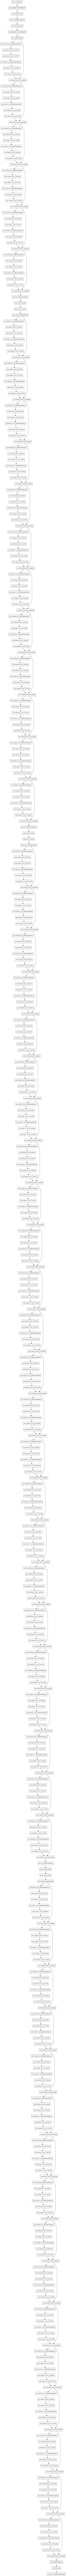

In [ ]:
tf.keras.utils.plot_model(final_chexnet_model)

In [ ]:
image_1= tf.keras.Input(shape=(224,224,3),name="image_1_features")
image_2= tf.keras.Input(shape=(224,224,3),name="image_2_features")
image_1_out=final_chexnet_model(image_1)
image_2_out=final_chexnet_model(image_2)
conc=tf.keras.layers.Concatenate(axis=-1)([image_1_out,image_2_out])
feature_extraction_model=Model(inputs=[image_1,image_2],outputs=conc)

In [ ]:
print(feature_extraction_model)

In [ ]:
print(image_1_out)

KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), name='Chexnet_model/avg_pool/Mean:0', description="created by layer 'Chexnet_model'")


In [ ]:
# encoder_decoder.load_weights('/content/drive/MyDrive/Medical_report_generation_2023/Reboot/Results/MedGen-main/MedGen-main/features/encoder_decoder_epoch_10.h5')

In [ ]:
from matplotlib.pyplot import imshow

In [ ]:
# encoder_decoder.load_weights('/content/drive/MyDrive/Medical_report_generation_2023/Reboot/Results/MedGen-main/MedGen-main/features/encoder_decoder_epoch_10.h5')

In [ ]:
def evaluation(image1,image2):
    image_features=feature_extraction_model([image1,image2])
    output_report=''
    input_rep= 'startseq'
    image_features=tf.reshape(image_features,shape=(-1,image_features.shape[-1]))
    
    for i in range(max_len):
        input_tokens = [tokenizer.word_index[w] for w in input_rep.split()]
        input_padded = tf.keras.preprocessing.sequence.pad_sequences([input_tokens],max_len, padding='post')
        results = encoder_decoder.predict([image_features,input_padded])
        arg = np.argmax(results[0]) 
        if tokenizer.index_word[arg]=='endseq':
            output_report+=tokenizer.index_word[arg]+" "
            break
        else:
            input_rep = input_rep + ' ' + tokenizer.index_word[arg]
            output_report = output_report+tokenizer.index_word[arg]+" "
    return output_report

In [ ]:
def img_preprocess(img):
    img=img_to_array(img)
    img=preprocess_input(img)
    img=cv2.resize(img,(224,224))
    img=img/255.0
    img=np.expand_dims(img, axis=0)
    return img

1/1 [==============================] - 0s 36ms/step
Actual Report:  startseq the  examination consists of frontal and lateral radiographs of the chest there are diminished lung volumes the cardiomediastinal contours are within normal limits pulmonary vascularity is within normal limits no focal consolidation pleural effusion or pneumothorax identified  scoliosis is unchanged visualized upper abdomen is grossly unremarkable endseq
Generated Report:  the heart is normal in size the mediastinum is unremarkable the lungs are clear endseq 
BLEU SCORE IS:  1.2614963820891841e-231


/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

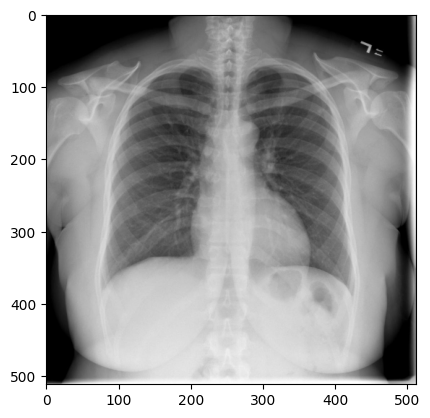

In [ ]:
img1=Image.open('/content/drive/MyDrive/Medical_report_generation_2023/Reboot/Results/MedGen-main/MedGen-main/data/sample/CXR1009_IM-0010-1001.png')
img2=Image.open('/content/drive/MyDrive/Medical_report_generation_2023/Reboot/Results/MedGen-main/MedGen-main/data/sample/CXR1009_IM-0010-2001.png')

imshow(np.asarray(img1))
img1=img_preprocess(img1)
img2=img_preprocess(img2)
result=evaluation(img1,img2) 
actual=y_test[0]

print("Actual Report: ",actual)
print("Generated Report: ",result) 
print("BLEU SCORE IS: ",sentence_bleu(actual,result))

1/1 [==============================] - 0s 20ms/step
Actual Report:  startseq the heart is enlarged the mediastinal contours are stable large hiatal hernia is identified containing stomach and colon questionable small bowel loops are also visualized inthe large hernia there is adjacent compressive atelectasis the lungs are clear endseq
Generated Report:  the heart is normal in size the mediastinum is unremarkable the lungs are clear endseq 
BLEU SCORE IS:  1.2454230825798051e-231


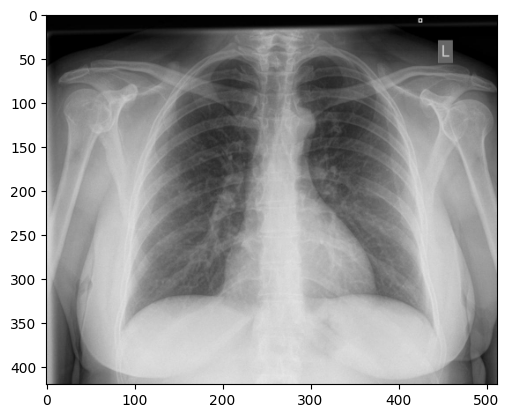

In [ ]:
img1=Image.open('/content/drive/MyDrive/Medical_report_generation_2023/Reboot/Results/MedGen-main/MedGen-main/data/sample/CXR1026_IM-0021-2002.png')
img2=Image.open('/content/drive/MyDrive/Medical_report_generation_2023/Reboot/Results/MedGen-main/MedGen-main/data/sample/CXR1026_IM-0021-2002.png')

imshow(np.asarray(img1))
img1=img_preprocess(img1)
img2=img_preprocess(img2)
result=evaluation(img1,img2) 
actual=y_test[4]
print("Actual Report: ",actual)
print("Generated Report: ",result) 
print("BLEU SCORE IS: ",sentence_bleu(actual,result))

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# encoder_decoder.save_weights('/content/drive/MyDrive/Medical_report_generation_2023/Reboot/Results/MedGen-main/MedGen-main/',save_format="tf")

In [ ]:
# encoder_decoder.save('/content/drive/MyDrive/Medical_report_generation_2023/Reboot/Results/MedGen-main/MedGen-main/epochs',save_format='h5')

In [ ]:
os.chdir('/content/drive/MyDrive/Medical_report_generation_2023/Reboot/Results/MedGen-main/MedGen-main/savedModel/')

In [ ]:
encoder_decoder.save('model.h5')